In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import unicodedata
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\april\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\april\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load and Preprocess Data

In [80]:
# Define column names
columns = [
    'filename', 'label', 'statement', 'subject', 'speaker', 
    'job_title', 'state', 'party', 'true_counts', 'false_counts',
    'half_true_counts', 'barely_true_counts', 'pants_fire_counts', 'context'
]

# Load the data
df = pd.read_csv('train.tsv', sep='\t', header=None, names=columns)

# Convert labels to binary (true/false) following svm.ipynb approach
def simplify_label(label):
    """Convert multi-class labels to binary (true/false)"""
    label = str(label).lower()
    return label in ['true', 'mostly-true', 'half-true', 'barely-true']

# Create binary labels
df['label'] = df['label'].apply(simplify_label)

# Create encoded labels
label_mapping = {False: 0, True: 1}
df['encoded_label'] = df['label'].map(label_mapping)


print("\nLabel distribution after binary conversion:")
df.head()

print(df['label'].value_counts())

print(f"Dataset shape: {df.shape}")


Label distribution after binary conversion:
label
True     7406
False    2834
Name: count, dtype: int64
Dataset shape: (10240, 15)


In [81]:
def categorize_subject(subject):
    """Categorize subjects into broader categories"""
    if pd.isna(subject):
        return 'other'
    
    subject = subject.lower()
    
    if any(word in subject for word in ['health', 'medicare', 'medicaid']):
        return 'healthcare'
    elif any(word in subject for word in ['economy', 'jobs', 'unemployment', 'taxes', 'budget']):
        return 'economy'
    elif any(word in subject for word in ['education', 'school', 'student']):
        return 'education'
    elif any(word in subject for word in ['immigration', 'border']):
        return 'immigration'
    elif any(word in subject for word in ['military', 'war', 'veteran']):
        return 'military'
    elif any(word in subject for word in ['environment', 'climate', 'energy']):
        return 'environment'
    elif any(word in subject for word in ['campaign', 'election', 'voting']):
        return 'political_process'
    else:
        return 'other'

# Clean and preprocess the data
def clean_data(df):
    # Drop rows with missing values in key columns
    df = df.dropna(subset=['subject', 'speaker'])
    
    # Create derived features
    df['statement_length'] = df['statement'].str.len()
    df['subject_category'] = df['subject'].apply(categorize_subject)
    
    # Clean party column
    df['party'] = df['party'].fillna('none')
    df['party'] = df['party'].astype(str).str.lower().str.strip()
    df['party'] = df['party'].replace('', 'none')
    
    # Fill missing values for job_title, state, and context with 'none'
    df['job_title'] = df['job_title'].fillna('none')
    df['state'] = df['state'].fillna('none')
    df['context'] = df['context'].fillna('none')
    
    return df

# Apply preprocessing
df = clean_data(df)

num_stats = df.describe().T[['min', 'max', 'mean', '50%', 'std']]
num_stats.rename(columns={'50%': 'median'}, inplace=True)
print("\nNumerical column statistics (min, max, mean, median, std dev):")
display(num_stats)


Numerical column statistics (min, max, mean, median, std dev):


,min,max,mean,median,std
true_counts,0.0,70.0,11.533210,2.0,18.973764
false_counts,0.0,114.0,13.286482,2.0,24.112936
half_true_counts,0.0,160.0,17.133718,3.0,35.846511
barely_true_counts,0.0,163.0,16.434265,3.0,36.151688
pants_fire_counts,0.0,105.0,6.201407,1.0,16.128927
encoded_label,0.0,1.0,0.723383,1.0,0.447347
statement_length,11.0,3204.0,106.863548,99.0,59.854423


In [82]:
def clean_text(text):
    """Clean and preprocess text data"""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize text"""
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join(lemmatizer.lemmatize(token) for token in tokens)

def preprocess_statement(statement):
    """Preprocess a single statement"""
    cleaned_text = clean_text(statement)
    return tokenize_and_lemmatize(cleaned_text)

# Process all statements
print("Processing statements...")
df['processed_statement'] = df['statement'].apply(preprocess_statement)
print("Statement processing complete!")

Processing statements...
Statement processing complete!
Statement processing complete!


## 2. Feature Engineering and Data Splitting

In [83]:
# Create TF-IDF vectorizer
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    stop_words='english'
)

# Split data
X = df['processed_statement']
y = df['encoded_label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Create TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Original class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

# Create a balancing pipeline
print("\nBalancing dataset...")
# First oversample the minority class with SMOTE
# Then undersample the majority class to create a perfectly balanced dataset
balancing_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('random_under', RandomUnderSampler(random_state=42))
])

# Apply balancing to TF-IDF features
X_train_balanced, y_train_balanced = balancing_pipeline.fit_resample(X_train_tfidf, y_train)

print("\nBalanced class distribution in training set:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

print(f"\nTraining set shape before balancing: {X_train_tfidf.shape}")
print(f"Training set shape after balancing: {X_train_balanced.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")

# Save the TF-IDF vectorizer for later use
print("\nSaving TF-IDF vectorizer...")
joblib.dump(tfidf, 'models/tfidf.joblib')

Creating TF-IDF features...
Original class distribution in training set:
encoded_label
1    0.723416
0    0.276584
Name: proportion, dtype: float64

Balancing dataset...

Balanced class distribution in training set:
encoded_label
0    0.5
1    0.5
Name: proportion, dtype: float64

Training set shape before balancing: (7166, 2279)
Training set shape after balancing: (10368, 2279)
Testing set shape: (3072, 2279)

Saving TF-IDF vectorizer...


['models/tfidf.joblib']

## 3. Model Training and Evaluation

In [ ]:
# Train and evaluate models with balanced dataset
models = {}
predictions = {}
model_scores = {}

# 1. Support Vector Machine
print("Training Support Vector Machine...")
svm = SVC(
    probability=True,
    random_state=42,
    kernel='linear', 
    C=1.0 
)
svm.fit(X_train_balanced, y_train_balanced)
svm_pred = svm.predict(X_test_tfidf)

models['SVM'] = svm
predictions['SVM'] = svm_pred
model_scores['SVM'] = {'probabilities': svm.predict_proba(X_test_tfidf)}

# 2. Naive Bayes
print("\nTraining Naive Bayes...")
nb = MultinomialNB()
nb.fit(X_train_balanced, y_train_balanced)
nb_pred = nb.predict(X_test_tfidf)

models['Naive Bayes'] = nb
predictions['Naive Bayes'] = nb_pred
model_scores['Naive Bayes'] = {'probabilities': nb.predict_proba(X_test_tfidf)}

# 3. Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20, 
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
rf.fit(X_train_balanced, y_train_balanced)
rf_pred = rf.predict(X_test_tfidf)

models['Random Forest'] = rf
predictions['Random Forest'] = rf_pred
model_scores['Random Forest'] = {'probabilities': rf.predict_proba(X_test_tfidf)}

Training Support Vector Machine...

Training Naive Bayes...

Training Random Forest...

Training Naive Bayes...

Training Random Forest...


In [85]:
# Evaluate models
print("Model Evaluation Results:\n")

for model_name, pred in predictions.items():
    accuracy = accuracy_score(y_test, pred)
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.3f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, pred, 
                              target_names=['False', 'True']))

Model Evaluation Results:


SVM:
Accuracy: 0.601

Classification Report:
              precision    recall  f1-score   support

       False       0.34      0.49      0.40       850
        True       0.77      0.64      0.70      2222

    accuracy                           0.60      3072
   macro avg       0.56      0.57      0.55      3072
weighted avg       0.65      0.60      0.62      3072


Naive Bayes:
Accuracy: 0.601

Classification Report:
              precision    recall  f1-score   support

       False       0.34      0.49      0.40       850
        True       0.77      0.64      0.70      2222

    accuracy                           0.60      3072
   macro avg       0.56      0.57      0.55      3072
weighted avg       0.65      0.60      0.62      3072


Random Forest:
Accuracy: 0.604

Classification Report:
              precision    recall  f1-score   support

       False       0.35      0.48      0.40       850
        True       0.77      0.65      0.70      2222


## 4. Visualizations

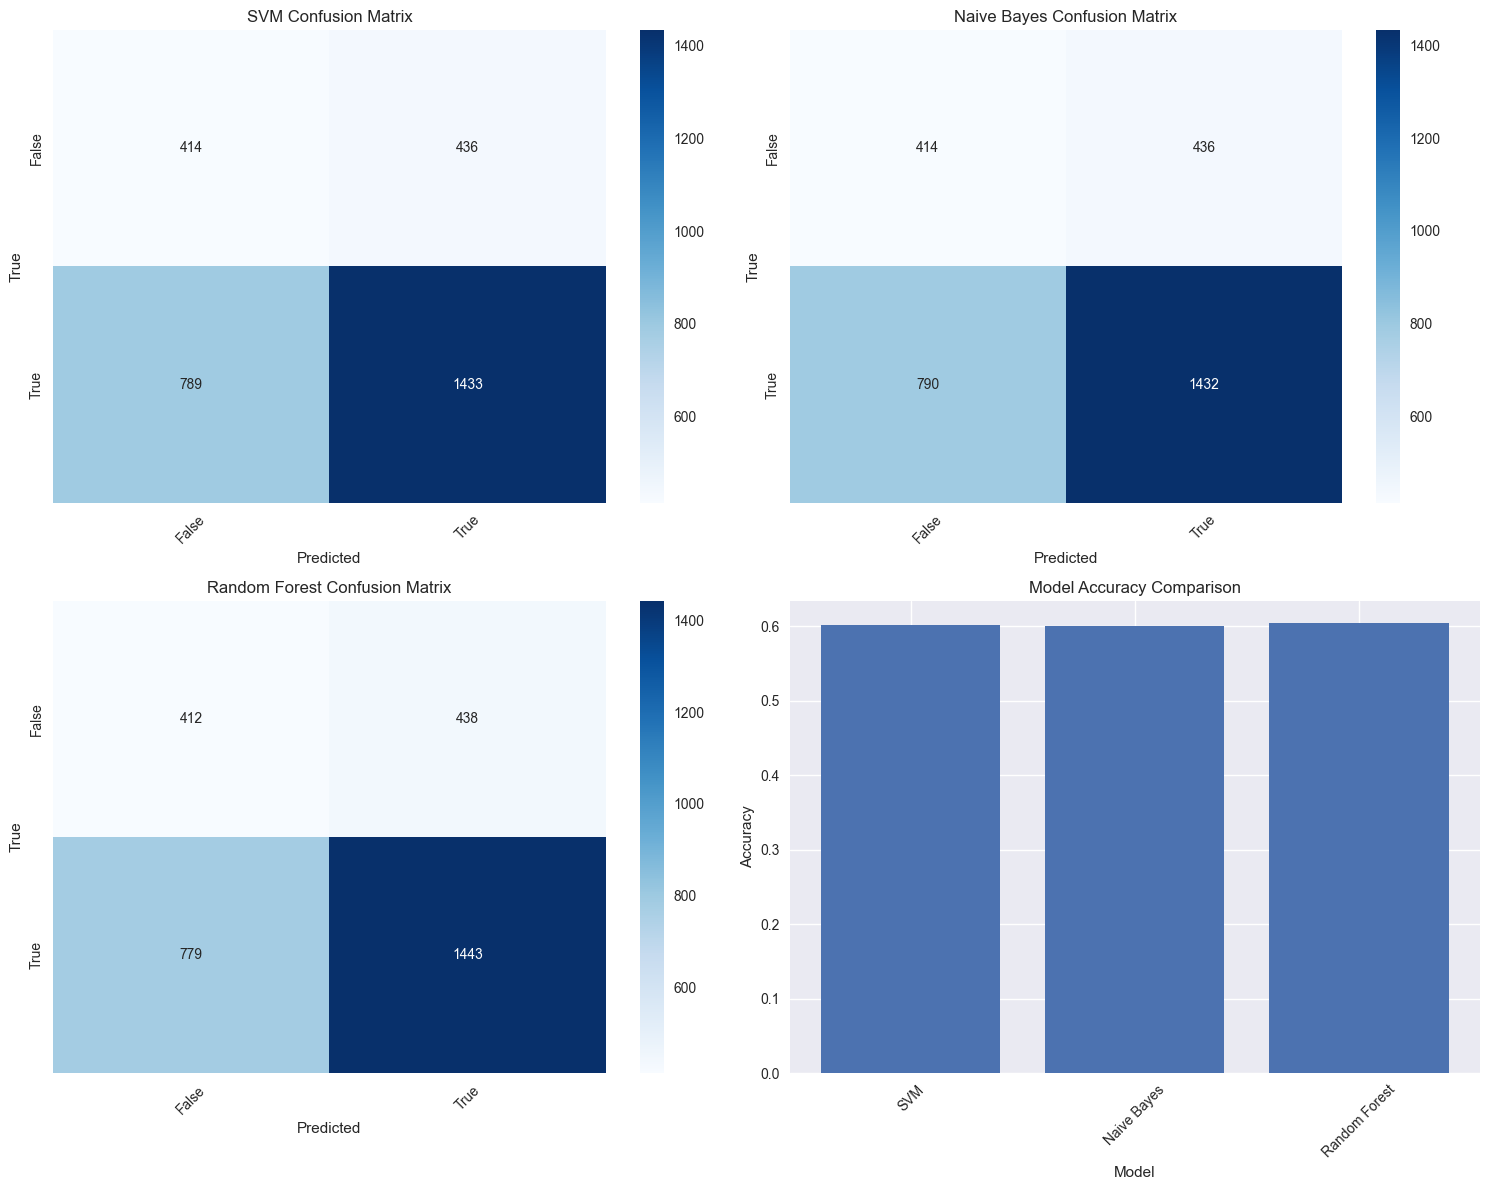

In [86]:
# Set up the visualization style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrices
for idx, (model_name, pred) in enumerate(predictions.items()):
    if idx < 3:  # We have 3 models
        plt.subplot(2, 2, idx+1)
        cm = confusion_matrix(y_test, pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['False', 'True'],
                   yticklabels=['False', 'True'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(rotation=45)

# 2. Model Comparison (Accuracy)
accuracies = [accuracy_score(y_test, pred) for pred in predictions.values()]
plt.subplot(2, 2, 4)
plt.bar(predictions.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5. Save Models

In [88]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save all models
for model_name, model in models.items():
    filename = f'models/{model_name.lower().replace(" ", "_")}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved {model_name} to {filename}")

Saved SVM to models/svm.pkl
Saved Naive Bayes to models/naive_bayes.pkl
Saved Random Forest to models/random_forest.pkl
